#  Weights and Biases

In [1]:
# WandB – Install the W&B library
!pip install wandb -qqq
import wandb
import os
os.environ['WANDB_MODE'] = 'offline'
os.environ['WANDB_NOTEBOOK_NAME'] = './Training_DiffSize_Different_Graph'
wandb.login()

wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find ./Training_DiffSize_Different_Graph.
wandb: Currently logged in as: bhandk. Use `wandb login --relogin` to force relogin


True

# Training 


In [4]:
"""DQN agents trained on Breakthrough by independent Q-learning."""
from utils.environment.game import GraphGame
from utils.reinforcement_learning.rl_environment import Environment
from utils.validation import get_Validation,area_under_curve
#from utils.reinforcement_learning.dqn import DQN
from utils.reinforcement_learning.dqn import DQN
from utils.params import Params

from tqdm import tqdm
import torch
import copy
import numpy as np
from datetime import datetime

#WandB Alert
from datetime import timedelta
from wandb import AlertLevel


# DQN model hyper-parameters
params = Params("./utils/mixed_params.json")

#epsilon_decay_duration= int(2e6) if num_train_episodes == int(1e5) else int(2e7)
# WandB – Initialize a new run
now = datetime.now()
wandb.init(entity="bhandk", project="Attack_and_Defense_Different_Graph_Type",name=now.strftime("%d/%m/%Y %H:%M:%S"),config=params)
wandb.watch_called = False # Re-run the model without restarting the runtime, unnecessary after our next release


def Generate_Batch_Graph(size,seed = None):
    graph_type = ['erdos_renyi', 'powerlaw','small-world', 'barabasi_albert']
    Batch_Graph = [gen_new_graphs(graph_type,seed=seed+i) for i in range(size)]
    return np.array(Batch_Graph,dtype=object)
evaluation, eval_x = get_Validation(params.validation_test_size)#get_Validation(4,file_path)

def main(agents=None):
    game = "graph_attack_defend"
    env = Environment(game)
    num_actions = env.action_spec()["num_actions"]
    size_CV = params.validation_test_size
    CV_AUC = []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if agents == None:
        agents = DQN(
                player_id=0,
                state_representation_size=params.centrality_features,
                global_feature_size = params.global_features,
                num_actions=num_actions,
                hidden_layers_sizes=params.hidden_layers,
                replay_buffer_capacity=int(params.replay_buffer_capacity),
                learning_rate=params.learning_rate,
                update_target_network_every=  params.update_target_network_every,
                learn_every=params.learn_every,
                discount_factor=params.discount_factor,
                min_buffer_size_to_learn=params.min_buffer_size_to_learn,
                power = params.epsilon_power,
                nsteps=params.nstep,
                epsilon_start=params.epsilon_start,
                epsilon_end=params.epsilon_end,
                epsilon_decay_duration=params.epsilon_decay_duration,
                batch_size=params.batch_size)
    
    #agents.append(random_agent.RandomA1gent(player_id=1, num_actions=num_actions))
    wandb.watch(agents[0]._q_network, log="all")
    graph_batch_size = params.graph_batch_size
    for ep in tqdm(range(int(params.num_train_episodes))):
        if (ep) % params.graph_suffle == 0:
            Batch_Graph = Generate_Batch_Graph(params.graph_batch_size,seed=ep)
        time_step = env.reset(Batch_Graph[int(ep%graph_batch_size)].copy())
        #time_step = env.reset(gen_new_graphs())
        while not time_step.last():
            action, prob = agent.step(time_step)
            time_step = env.step(action)
        # Episode is over, step all agents with final info state.
        for agent in agents:
            agent.step(time_step)
        #if agents[0]._last_loss_value != None:
        wandb.log({"loss": agents[0]._last_loss_value,"cummulative_reward":env.get_state._returns[0],"epsilon":agents[0].epsilon})
        if (ep + 1) % params.eval_every == 0:
            AUC = []
            for i in range(size_CV):
                eval_step = env.reset(evaluation[i].copy())
                while not eval_step.last():
                    eval_output, prob = agent.step(eval_step, is_evaluation=True)
                    eval_step = env.step(eval_output)
                lcc = env.get_state.lcc
                AUC.append(area_under_curve(eval_x[i][:len(lcc)],lcc))
            #wandb.log({"Eval_Homogeneous": np.mean(AUC[0:int(size_CV/2)]),"Eval_Heterogeneous":np.mean(AUC[int(size_CV/2):int(size_CV)])  })
            meanAUC = np.mean(AUC)
            CV_AUC.append(meanAUC)
            wandb.log({"Evaluation_Dataset": meanAUC})          
        if (ep + 1) % params.save_every == 0:
            checkpoint = {'_q_network': agents[0]._q_network.state_dict(),'target_q_network': agents[0]._target_q_network.state_dict(),'_optimizer' :agents[0]._optimizer.state_dict()}
            title = params.checkpoint_dir+"_"+str(ep+1)
            torch.save(checkpoint, title)
    wandb.finish()
    return agents, CV_AUC
agents = None#[torch.load('./model/DiffSize_Different_Graph/model_differentGraph_100000')]
agents, CV_AUC= main(agents)    

100%|█████████████████████████████████████████████████████| 500000/500000 [46:05:59<00:00,  3.01it/s]


Evaluation_Dataset,▂▃▁▂▂▂▂▂▃▂▃▂▂▂▃▄▄▃▄▃▅▄▅▅█▅█▇▆▂▆▁▁▁▁▂▁▁▁▁
cummulative_reward,▃▇▆▂▆▄▃▁▆▄▃▄▂▂▄▃▇▁█▃▂▃▄▅▅▃▄▆▅▄▇▆█▆▇▆▆▂▃▆
epsilon,██▇▇▆▆▆▆▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
loss,▂▂▁▁▃▂▂▂▃▂▃▄▂▃▂▂▁▁▂▂▁▁▁▁▂▂▁▃▂▄▃▃▂▁█▂▂▂▃▄
Evaluation_Dataset,10.95641
cummulative_reward,1.5532
epsilon,0.13648
loss,0.01214


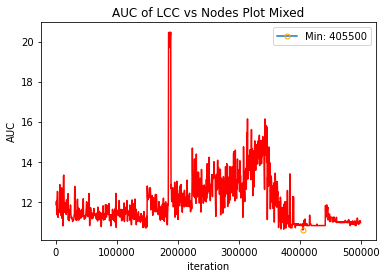

In [5]:
CV_AUC = np.array(CV_AUC)
save_every= 500            
num_train_episodes = int(5e5) 
x = np.arange(500,num_train_episodes+save_every,save_every)
min_value = np.argmin(CV_AUC)
min_vc = x[min_value]
plt.plot(x,CV_AUC,color='red')
plt.plot(min_vc, CV_AUC[min_value], marker="o", markersize=5, markeredgecolor='orange', markerfacecolor="None",label="Min: "+str(min_vc))
plt.title("AUC of LCC vs Nodes Plot Mixed")
plt.xlabel("iteration")
plt.ylabel("AUC")
plt.legend()
plt.savefig("./Evaluation_Notebook/Figure/eval_200_Mixed")
plt.show()

# END